# Introduction

Perception and reasoning are two representative abilities of intelligence that are
integrated seamlessly during human problem-solving processes. In the area of
artificial intelligence (AI), the two abilities are usually realised by machine learning
and logic programming, respectively.

In this notebook,
we demonstrate abductive learning, which is targeted at unifying the two AI paradigms in
a mutually beneficial way, where the machine learning model learns to perceive
primitive logic facts from data, while logical reasoning can exploit symbolic domain
knowledge and correct the wrongly perceived facts for improving the machine
learning models. 

The primary
difficulty lies in the fact that the machine learning and symbolic models can hardly be trained together.
More concretely: 1) the machine learning model does not have any ground-truth of the labels for training the machine learning model; 2) if the machine learning model does not predict the labels accurately, the reasoning model can hardly deduce the correct output or learn the right logical theory.

Given observed facts and background knowledge expressed as first-order logical clauses, logical abduction can abduce ground hypotheses as possible explanations to the observed facts. Thus, it can be used to guess the missing information, for example, logic clauses that complete the background knowledge, or the appropriate labels for the Machine Learning function. These labels can then be used to train the Machine Learning model.

We demonstrate
that by using abductive learning, machines can learn to recognise numbers and
resolve unknown mathematical operations simultaneously from images of simple
hand-written equations.

### Installing Required Libraries


In [1]:
!unzip -q /content/drive/MyDrive/AbductiveLearning/dataset.zip #Please change this to whatever path you have saved dataset.zip
!pip install zoopt

replace dataset/random_images/0/v2-75554.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Generating the Dataset

We generate a dataset of equations for the Handwritten Equations task

In this task, equations are constructed from images of symbols (“0”, “1”, “+” and “=”), and they are generated with unknown
operation rules, each example is associated with a label that indicates whether the equation is correct. A machine is tasked with learning from a training set of labelled equations, and the trained model is expected to predict unseen equations correctly. Thus, the machine needs to learn image recognition (perception) and mathematical operations for calculating the equations (reasoning) simultaneously. The images for "0"s and "1"s are taken from the MNIST dataset.

In [2]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
import torchvision
import torch
random.seed(10)

writer = SummaryWriter()

def generate_equations(min_len=1,max_len=8,no_of_samples=6600,operator='xor'):
    '''
    Generates equations of the form X+Y=Z, where X,Y,Z are binary numbers and + represents the 'xor' operator
    The number of bits in each number will be between min_len and max_len
    Total number of equations generated will be no_of_samples
    '''
    equations=[]
    labels=[]
    for i in range(no_of_samples):
      # print(i)
      len=random.randint(min_len,max_len)
      left_op=random.randint(1,(2**len)-1)
      right_op=random.randint(1,(2**len)-1)
      if i%2==0:
      # if i%5!=0:
        result=left_op^right_op
        labels.append(1)
      else:
        result=random.randint(1,(2**len)-1)
        while(result==left_op^right_op):
          result=random.randint(1,(2**len)-1)
        labels.append(0)
      equation=""
      equation+=str(bin(left_op).replace("0b", "")).zfill(len)
      equation+="+"
      equation+=str(bin(right_op).replace("0b", "")).zfill(len)
      equation+="="
      equation+=str(bin(result).replace("0b", "")).zfill(len)
      equations.append(equation)
    return equations,labels
  
def generate_equation_images(eqs,signs,shape,image_pools):
  '''
  Given a set of equations in the form of strings. For ex. '1110+0001=1111', generate the corresponding handwritten equations,
  that is, replace the digits '1' and '0' with MNIST images and similarly for '+' and '='.
  '''
  sign_num = len(signs)
  char_index_dict = dict(zip(signs, list(range(sign_num))))
  eq_images=[]
  for eq in eqs:
    eq_image=[]
    for char in eq:
      index = char_index_dict[char]
      index2 = random.randint(0, len(image_pools[index]) - 1)
      image = Image.open(image_pools[index][index2]).convert('I').resize(shape)
      image_array = np.array(image)
      image_array = (image_array-127)*(1./128) 
      eq_image.append(image_array)
    eq_images.append(np.array(eq_image))
    # print(eq_images[-1].shape)
  return eq_images


def get_image_pools(data_dir, sign_names):
    '''
    Load directories containing images into memory
    '''
    sign_num = len(sign_names)
    index_dict = dict(zip(sign_names, list(range(sign_num))))
    ret = [[] for _ in range(sign_num)]
    for path in os.listdir(data_dir):
        if (path in sign_names):
            index = index_dict[path]
            sign_path = os.path.join(data_dir, path)
            for p in os.listdir(sign_path):
                ret[index].append(os.path.join(sign_path, p))
    return ret

def split_pool(pools, rate):
  '''
  Split a pool of images into train and test sets. 
  Ensures that the images used in equations of the test set, have not been seen 
  '''
  train_pool = []
  test_pool  = []
  for pool in pools:
      random.shuffle(pool)
      num = int(len(pool) * rate)
      train_pool.append(pool[:num])
      test_pool.append(pool[num:])
  return train_pool, test_pool

def display_equations(eqs,labels):
  '''
  From a set of equations, display one positive and one negative sample on screen
  '''
  print("Positive Sample")
  first_1_idx = next((x for x in range(len(labels)) if labels[x]==1), None)
  display_multiple_img(eqs[first_1_idx],cols=eqs[first_1_idx].shape[0],text="Positive Sample")
  print("Negative Sample")
  # print(labels)
  first_0_idx = next((x for x in range(len(labels)) if labels[x]==0), None)
  display_multiple_img(eqs[first_0_idx],cols=eqs[first_0_idx].shape[0],text="Negative Sample")


def matplotlib_imshow(img, one_channel=False):
  '''
  helper function to show an image
  '''
  if one_channel:
      img = img.mean(dim=0)
  img = img / 128 + 127     # unnormalize
  npimg = img.numpy()
  if one_channel:
      plt.imshow(npimg, cmap="Greys")
  else:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def display_multiple_img(images, rows = 1, cols=1,text=""):
  '''
  Display an equation on screen
  '''
  images=np.reshape(images,(images.shape[0],1,images.shape[1],images.shape[2]))
  img_grid = torchvision.utils.make_grid(torch.tensor(images),nrow=30)
  matplotlib_imshow(img_grid, one_channel=True)


In [3]:
from sklearn.model_selection import train_test_split
eqs,labels=generate_equations()
print(eqs)
print(labels)
train_eqs,test_eqs,train_labels,test_labels=train_test_split(eqs,labels,train_size=0.8)
image_pools = get_image_pools("/content/dataset/mnist_images", ['0', '1', '10', '11']) #if not using colab , change path to ./dataset/mnist_images
train_pool, test_pool = split_pool(image_pools, 0.8)
train_eq_images=generate_equation_images(train_eqs,['0', '1', '+', '='],(28,28),train_pool)
test_eq_images=generate_equation_images(test_eqs,['0', '1', '+', '='],(28,28),test_pool)


['1+1=0', '1+1=1', '10101+11010=01111', '001+101=011', '01+11=10', '000011+011011=111000', '101+011=110', '0110110+0100101=1101010', '01111+00110=01001', '10110+01100=00101', '11000101+11011101=00011000', '1000+1010=0111', '1+1=0', '010+011=101', '110010+111010=001000', '0110+1011=1001', '01110000+01111001=00001001', '11+11=10', '111+010=101', '0011111+0000101=0000101', '01001110+11010010=10011100', '11+01=01', '1001001+1111010=0110011', '111011+100111=001010', '01+10=11', '111+010=011', '1111101+0110110=1001011', '00111111+10101111=01000111', '101+101=000', '111+001=011', '01001110+00101011=01100101', '111+010=100', '010101+011100=001001', '0001+1001=1100', '1+1=0', '0010+0101=1000', '1001011+0010101=1011110', '1110110+1110000=1000000', '1100+1001=0101', '10001+10000=10100', '00010001+00101011=00111010', '10101101+01110111=11100110', '0010010+0110110=0100100', '100011+011001=100000', '101+100=001', '10+01=01', '10001010+00010001=10011011', '1+1=1', '11+10=01', '00100100+01110110=11011

Let's look at some of the equations we have generated.

Positive Sample


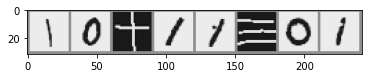

Negative Sample


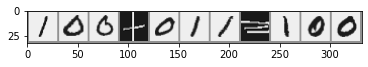

In [4]:
display_equations(train_eq_images,train_labels)

# Problem Setting

The input of abductive learning consists
of a set of labelled training data D = {<x1 ,y1> , . . . , <xn , yn>} about a target concept C and a
domain knowledge base B, where xi ∈ X is the input data, yi ∈ {0, 1} is the label for xi.

The target of abductive learning is to output a hypothesis model
H = p ∪ ∆ , in which:
* p : X → P is a mapping from the feature space to primitive symbols, i.e., it is a perception model formulated as a conventional machine learning model;
* ∆ is a set of first-order logical clauses that define the target concept C with B.

The hypothesis model should satisfy:
∀xi, yi ∈ D (B ∪ ∆ ∪ p(x) |= y).


# Defining the CNN

The CNN is used for classifying the symbols in the dataset, i.e, it learns the mapping p: X → P, which in this case, is a mapping from images to labels in the set {0,1,+,=}. Note that, the CNN will initially be trained on random labels, which need to fixed iteratively



In [5]:
import torch


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 4)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()
        # self.criterion = torch.nn.CrossEntropyLoss()
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

    def train(self,X,y,epochs,optimizer,criterion):
      losses=[]
      for i in range(epochs):
        optimizer.zero_grad()
        pred = self(X)
        # print(pred,y)
        loss = criterion(pred, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
      # plt.plot(losses)
      return np.array(losses)

# Defining the Abductive Learning Program

The abductive learning program needs to learn a set of logical clauses ∆, such that (B ∪ ∆ ∪ p(x) |= y).

For the handwritten equation task, the background knowledge is as follows:

1. We know the structure of the equation, that is, digit is a sequence of “0”s
and “1”s, and each equation has structure X+Y=Z.
2. '+' is known to be a bit-wise operation, and as the digits are binary, '+' could represent any one of the 16 binary operators. We know that the equation can be calculated bit-by-bit, starting from the left and moving towards the right
3. X,Y and Z have constant length

Thus, we have all the information to calculate an equation, except which of the 16 operators '+' represents. That means that, the program does not know whether 0+0 is 1 or 0,(similarly for 0+1,1+0,1+1) and these missing calculation rules need to be learnt from data. This is what we try to learn using logical abduction.

We encode each possible operator(f) as an integer in the range 0 to 15 (i.e 4-bit binary integers, of the form abcd), as follows:

a=f(1,1)

b=f(1,0)

c=f(0,1)

d=f(0,0)

Thus, the xor operator, will be encoded as 0110, whose integer value is 6

The consistency_score() does the abduction. It finds the operator which gives the maximum number of consistent equations, given a dataset consisting of equations and labels. The definition of consistency_score is explained in more detail in later sections


In [6]:
def check_f(left_op,right_op,result,f):
  '''
  Checks if f(left_op,right_op) is equal to result or not
  Returns 1 if yes, 0 otherwise
  '''
  if len(left_op)!=len(right_op):
    return -1
  if len(right_op)!=len(result):
    return -1
  func=np.zeros((2,2))
  func[0][0]=f%2
  f=f>>1
  func[0][1]=f%2
  f=f>>1
  func[1][0]=f%2
  f=f>>1
  func[1][1]=f%2
  # print(func)
  # print(left_op,right_op,result)
  for a,b,c in zip(left_op,right_op,result):
    # print("yoo",a,b,c)
    if func[int(a)][int(b)]!=int(c):
      return 0
  return 1

def evaluate(eq,f):
  '''
  Check whether a given equation is consistent given an operator f
  Returns 1 if consistent ,0 if not consistent and -1 if equation does not have correct structure
  '''
  left_op=[]
  right_op=[]
  result=[]
  i=0
  while i<len(eq) and eq[i]!=2:
    if eq[i]==3:
      return -1
    else:
      left_op.append(eq[i])
    i+=1
  if i==len(eq):
    return -1
  i+=1

  while i<len(eq) and eq[i]!=3:
    if eq[i]==2:
      return -1
    else:
      right_op.append(eq[i])
    i+=1
  if i==len(eq):
    return -1
  i+=1

  while i<len(eq):
    if eq[i]>=2:
      return -1
    else:
      result.append(eq[i])
    i+=1
  # print(left_op,right_op,result)
  return check_f(left_op,right_op,result,f)
  

  
  
  

In [7]:

def modify_equation(eq):
    '''
    Assign the value of '+' and '='  at the correct positions
    '''
    length=len(eq)
    size_of_num=int((length-2)/3)
    eq[size_of_num]=2
    eq[2*size_of_num+1]=3
    return eq

def modify(eqs):
  '''
  Calls modify_equation for each equation in the input
  '''
  ans=[]
  for eq in eqs:
    ans.append(modify_equation(eq))
  return ans

def consistency_score(eqs,labels,background_knowledge=True):
  '''
  For a set of equations and labels, iterates over all operators and finds the one with maximizes Con(H ∪ D; B).
  Returns the value of Con(H ∪ D; B) and the operator which maximizes it, alongside the indices of the equations which were consistent
  If background_knowledge is set as True, it assumes we know that number of bits in each number is the same, and assigns the value of '+' and '=' automatically at the correct positions
  '''
  max=0
  best_f=-1
  best_eqs=[]
  for f in range(16):
    count=0
    correct_eqs=[]
    i=0
    for eq,label in zip(eqs,labels):
      if background_knowledge:
        eq=modify_equation(eq)
      if evaluate(eq,f)==label:
        count+=1
        correct_eqs.append(i)
      i+=1
    if count>max:
      best_f=f
      max=count
      best_eqs=correct_eqs
  return (max,best_f,best_eqs)


# Optimization

ABL tries to maximise the consistency between the abduced hypotheses
H with training data D, given background knowledge B. It can be defined as 

Con(H ∪ D; B)= max |Dc|, where Dc⊆D

s.t. ∀ <xi,yi>  ∈ Dc (B ∪ ∆ ∪ p(xi) |= yi).

The consistency_score() operator defined above calculates the value of Con(H ∪ D; B) for our task. It iterates over all possible operators, and returns the one which maximizes this score.

During the t-th epoch, when the perception model p is under-trained, the pseudo-labels p(X) could
be incorrect and make logical abduction fail to abduce any consistent ∆ resulting
in Con(H ∪ D; B) = 0.

Therefore, ABL needs to correct the wrongly perceived pseudo-labels to achieve consistent abductions,
such that ∆  can be consistent with as many as possible examples in D. Here we denote the pseudo-labels to be revised as δ[p(X)] ⊆ p(X), where δ is a hueristic function

After removing the incorrect pseudo-labels marked by the δ function, ABL can apply logical abduction to abduce the candidate labels to replace δ[p(X)] with a new set of labels ∆p.


Theoretically, δ can simply mark all pseudo-labels as “wrong”, i.e., letting δ[p(X)] = p(X) and
ask logical abduction to do all the learning jobs. In this case, ABL can always abduce a consistent ∆p ∪ ∆. However, this means that the logical abduction have to learn the
knowledge model ∆ without any influence from the perception model p and the raw data X. Consequently, we choose to restrict the revision to
be not too far away from the percieved results, by limiting |δ[p(X)]|≤ M

Therefore, the final optimization problem is the following:

max<sub>δ</sub>  Con(Hδ ∪ D),

s.t |δ[p(X)]| ≤ M

Here, Hδ is the new hypothesis, in which the labels in δ[p(X)] have been replaced by ∆p.

This can be solved using Gradient Free Optimization methods. We use the POSS[2]  algorithm, which has been implemented in the zoopt[1] library. In one of our ablation experiments, we use a simple greedy search instead of POSS.

In my implementation, I make a slight modification to the algorithm used in the paper. For only the first iteration, I remove the constraint during the optimization. This allows the model to reach a good starting point, from where it can be improved iteratively.

The optimize_minibatch() function does this optimization. Given a set of labels p(x), it returns a revisied set of labels, i.e.  p(X) - δ[p(X)] ∪ ∆p, which maximizes the consistency score.

The constraint |δ[p(X)]| ≤ M, is implemented using the constraint() function. We choose M to be  $\sum$ length(equations)/10, for our task. The function returns a positive value if the constraint is satisfied, and a negative value if it is not. This function is passed as a parameter to the optimize_minibatch() function.




In [8]:
from collections import Counter
def reshape(eqs,flat_eqs):
  '''
  Given a 1D-List, reshape it to a 2D-List having same shape as eqs
  '''
  ans=[]
  i=0
  for eq in eqs:
    ans.append(flat_eqs[i:i+len(eq)])
    i+=len(eq)
  return ans

def reshape_and_get_score(eqs,flat_eqs,labels,background_knowledge=True):
  '''
  Reshape flat_eqs to a 2D-List, then returns consistency score for that 2D-List
  '''
  reshaped_eqs=reshape(eqs,flat_eqs)
  return consistency_score(reshaped_eqs,labels,background_knowledge)

def constraint(solution,ratio,og):
    '''
    This function implements the constraint δ[p(X)] ≤ M
    It ensures that a max of len(solution)*ratio bits are different between the vectors solution and og
    '''
    # print("solution=",solution.get_x())
    # print("og=",og,"ratio=",ratio)
    max_diff=ratio*len(og)
    count=0
    for a,b in zip(solution.get_x(),og):
      if a!=b:
        count+=1
    # print("diff=",max_diff-count)
    return max_diff-count

def greedy_step(eqs,res,labels):
  '''
  Take a single greedy step.
  Try changing the value of each bit, and keep the change only for the value which maximizes consistency_score
  '''
  max_score=reshape_and_get_score(eqs,res,labels)[0]
  best_index=-1
  for i in range(len(res)):
    temp=res[i]
    res[i]=0 if res[i]>0 else 1
    score=reshape_and_get_score(eqs,res,labels)[0]
    res[i]=temp
    if score>max_score:
      max_score=score
      best_index=i
  if best_index > -1:
    res[best_index]=0 if res[best_index]>0 else 1
  return res

def optimize_greedy(eqs,res,labels):
  '''
  Relabel a set of equations using greedy algorithm
  '''
  for i in range(int(len(res)/10)):
    res=greedy_step(eqs,res,labels)
  return res


def optimize_minibatch(eqs,res,labels,budget,constraint=None,background_knowledge=True,greedy=False):
  '''
  Relabel a set of equations, in such a manner that it optimizes the consistency score
  Returns the new set of equations after relabelling
  If greedy is True, uses greedy approach for optimization
  Else if constraint is not None, uses POSS
  Else it uses RACOS
  If background_knowledge is true, only 0s and 1s have to be relabelled
  however if background knowledge is False, any position in the equation can be assigned 0,1,+ or = 
  '''
  if greedy:
    return optimize_greedy(eqs,res,labels)
  dim_size = 1 if background_knowledge else 3
  dim = Dimension(len(res), [[0, dim_size]] * len(res),[False] * len(res))
  obj = Objective(lambda x: -reshape_and_get_score(eqs,x.get_x(),labels,background_knowledge)[0],dim,constraint=constraint)
  param = Parameter(budget=budget, autoset=True)
  solution = Opt.min(obj, param)
  return solution

def decode(eqs,debug=False):
  '''
  Helper function, converts an equation in the form of a list to a string.
  '''
  ans=[]
  for eq in eqs:
    temp=''
    if debug:
      print(eq)
    for label in eq:
      if label<=1:
        temp+=str(int(label))
      elif label==2:
        temp+='+'
      else:
        temp+='='
    ans.append(temp)
  return ans


# Training

Finally, lets put it all together, into the training loop.

The training algorithm is as follows:

1. Initialize the CNN model p
2. For N epochs do:

  3. Sample a batch of equations D' from the Dataset D.
  4. Let c_score be Con(H ∪ D'; B)
  5. Call the optimization module, to get the updated labels: p(X) - δ[p(X)] ∪ ∆p
  6. Let c_score_new be Con(Hδ ∪ D'; B)
  7. If c_score_new>c_score
    8. Retrain the CNN model on the updated labels, for the equations which are consistent given the new labels.


Note that logical abduction is done in steps 4 and 6. To calculate the consistency score, we first find the operator which maximizes the score, and then returns the score corresponding to that operator


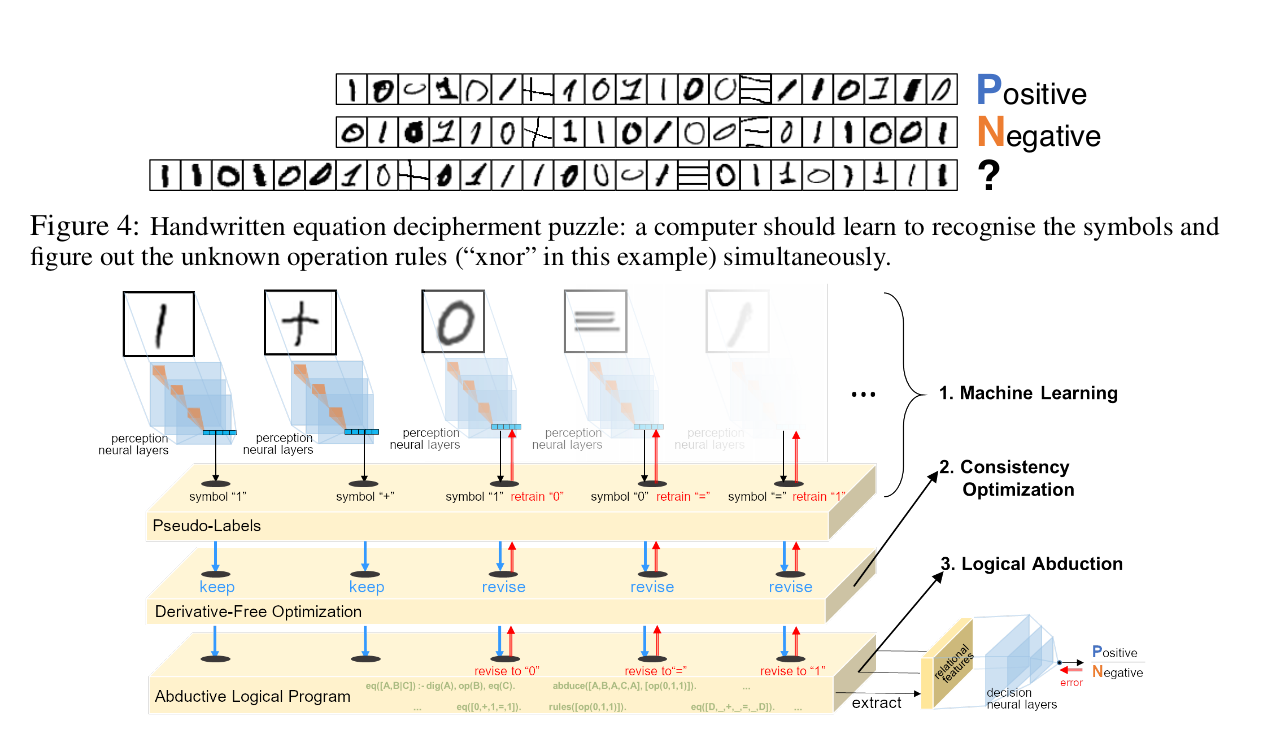

In [9]:

from zoopt import Dimension, Objective, Parameter, Opt, Solution
from itertools import chain
from functools import partial
import math
import copy
def train_minibatch(model,train_eq_images,train_eqs,train_labels,batch_size,no_of_epochs_outer=100,no_of_epochs_inner=10,budget=100,constr=1,background_knowledge=True,greedy=False,best_model=False,text="Default"):
  '''
  Trains a model using the Abductive Learning procedure defined above.

  no_of_epochs_outer specifies the number of iterations to run in outer loop
  no_of_epochs_inner specifies the number of iterations to train the CNN model in each iteration of the outer loop
  budget - used by optimization module
  constr - specifies the ratio of elements which can be changed by the optimization module
  background_knowledge - if this is true, it assumes the length of each number in an equation is constant
  greedy - if this is True, it uses greedy algorithm for optimization instead of RACOS/POSS
  best_model - if this is True, it returns model which had minimum loss during entire training process, else it returns the model at the end of the training process

  Returns the model after training and a list containing loss at each iteration
  '''
  optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
  losses=[]
  min_loss=math.inf
  best_model=model
  for i in range(no_of_epochs_outer):
    print("iteration #",i)
    # sample a batch of equations
    indices=random.sample(range(len(train_eq_images)),batch_size)
    eqs=[train_eq_images[i] for i in indices]
    eqs_expected=[train_eqs[i] for i in indices]
    flatten_eqs = list(chain.from_iterable(eqs))
    print("the equations in this batch are",eqs_expected)
    flatten_eqs=np.array(flatten_eqs)
    flatten_eqs=torch.tensor(flatten_eqs.reshape((flatten_eqs.shape[0],1,flatten_eqs.shape[1],flatten_eqs.shape[2])))
    labels=[train_labels[i] for i in indices]
    # get the  consistency score before optimization
    res=model(flatten_eqs.float())
    res=np.argmax(res.detach(),axis=1)
    print("equations before opti",decode(reshape(eqs,res.detach())))
    print("labels=",labels)
    c_score=-reshape_and_get_score(eqs,res,labels,background_knowledge)[0]
    print("c-score before opti",c_score)
    # optimize labels
    if constr==1 or i==0:
      c=None
    else:
      c=partial(constraint,ratio=constr,og=res)
    optimized_res=optimize_minibatch(eqs,res,labels,budget=budget,constraint=c,background_knowledge=background_knowledge,greedy=greedy if i else False)
    soln = optimized_res if greedy and i else optimized_res.get_x()
    if background_knowledge:
      print("equation after opti",decode(modify(reshape(eqs,soln)),debug=False))
    else:
      print("equation after opti",decode(reshape(eqs,soln),debug=False))
    # get consistency score after opti
    if (constr==1 and not greedy) or i==0:
      c_score_new=optimized_res.get_value()
    elif greedy:
      c_score_new=-reshape_and_get_score(eqs,soln,labels,background_knowledge=True)[0]
    else:
      if optimized_res.get_value()[1]<0:
        c_score_new=0.0
      else:
        c_score_new=optimized_res.get_value()[0]
    print("c-score after opti",c_score_new)
    if c_score_new>=c_score:
      print("skipping \n\n\n")
      continue
    ### Retrain model on new labels
    reshaped_ans=reshape(eqs,soln)
    correct_indices=consistency_score(reshaped_ans,labels)[2]
    correct_eqs=modify([reshaped_ans[i] for i in correct_indices]) if background_knowledge else [reshaped_ans[i] for i in correct_indices]
    correct_eq_images=[eqs[i] for i in correct_indices]
    print("Correct eqs=",decode(correct_eqs))
    flattened_correct_eqs=list(chain.from_iterable(correct_eqs))
    flattened_correct_eq_images=list(chain.from_iterable(correct_eq_images))
    flattened_correct_eq_images=np.array(flattened_correct_eq_images)
    print(flattened_correct_eq_images.shape)
    counts=Counter(np.array(flattened_correct_eqs))
    # print(counts)
    weight=torch.tensor([1/counts[0] if counts[0]>0 else 1,1/counts[1] if counts[1]>0 else 1,1/counts[2],1/counts[3]])
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    flattened_correct_eq_images=torch.tensor(flattened_correct_eq_images.reshape((flattened_correct_eq_images.shape[0],1,flattened_correct_eq_images.shape[1],flattened_correct_eq_images.shape[2])))
    loss=model.train(flattened_correct_eq_images.float(), torch.tensor(flattened_correct_eqs).long(),no_of_epochs_inner,optimizer,criterion)
    loss=loss/len(res)
    if min_loss>loss[-1]/len(res):
      best_model=copy.deepcopy(model)
      min_loss=loss[-1]/len(res)
    print("final loss=",loss/len(res))
    losses.append(loss[-1])
    writer.add_scalar("%s/train" %(text), loss[-1], i)
    print("model predictions after opti:",decode(reshape(correct_eq_images,np.argmax(model(flattened_correct_eq_images.float()).detach(),axis=1))))
    print("\n\n\n")
  if best_model:
    return best_model,losses
  return model,losses  


iteration # 0
the equations in this batch are ['101+101=001', '111+110=001', '1110101+1100110=0010110', '10101+00100=00101', '0111+1010=1101', '001+111=111', '0011011+0101001=0110010', '0101+1001=1100', '000101+111001=111100', '110000+001111=111111', '11+01=10', '01011010+00001100=10100000', '01100+01010=00110', '11+11=01', '1000+1111=0111', '1111101+0110110=1001011']
equations before opti ['+++1+++++++', '+++++++1+1+', '1++++++++++++++=+1+111+', '+++++++++1+++++1+', '1+++++++++++++', '+1+1+++1+++', '+1+++++1++++1++1+++++++', '1+++1+1+++++++', '+++++1++++11++++++++', '+++++11++1++++++++++', '++++++++', '1+1++++++++1+++++++1++++++', '+1++1++++++1+++++', '+++++111', '+++++++++1++++', '+++++11++++++++1+++++++']
labels= [0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1]
c-score before opti 0
[zoopt] x: [0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,

Text(0, 0.5, 'CNN Training Loss')

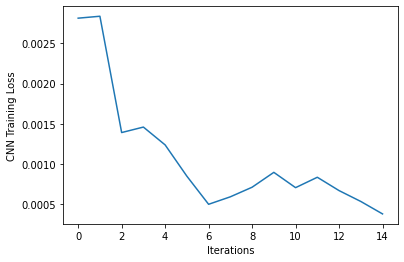

In [10]:
model=Model()
model,losses=train_minibatch(model,train_eq_images,train_eqs,train_labels,16,100,10,budget=1000,constr=0.1,text="ABL")
writer.flush()
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("CNN Training Loss")
# train_sgd(model,train_eq_images,train_labels,100,10)

### View smoothened loss curve

In [11]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 466), started 0:18:28 ago. (Use '!kill 466' to kill it.)

<IPython.core.display.Javascript object>

We can see that the CNN loss decreases during the training process. This shows that the CNN is able to benefit as the logical inferred labels get closer and closer to the ground truth labels


### Evaluation

We define a function which evaluates our model on the test set. Given a trained model and a test set, it returns the maximum consistency score which can be achieved on this set.


In [12]:
def eval(eq_images,labels,model,background_knowledge=True):
  '''
  Given a set of equations and the corresponding labels, find the consistency score if 'model' is used for perception.
  '''
  eqs=[]
  i=0
  for eq_image in eq_images:
    # print(i)
    i+=1
    eq_image=torch.tensor(eq_image.reshape((eq_image.shape[0],1,eq_image.shape[1],eq_image.shape[2])))
    res=model(eq_image.float())
    res=np.argmax(res.detach(),axis=1)
    eqs.append(res)
  ans=consistency_score(eqs,labels,background_knowledge)
#   print(ans)
  counts=Counter(labels)
  count0=counts[0]
  count1=counts[1]
  correct_labels=[labels[i] for i in ans[2]]
  correct_counts=Counter(correct_labels)
  correct0=correct_counts[0]
  correct1=correct_counts[1]
  accuracy=(correct0+correct1)/(count0+count1)
  precision=float(correct1)/(correct1+count0-correct0)
  recall=float(correct0)/(correct0+count1-correct1)
  print("%f %f %d %d" %(precision,recall,correct0,correct1))
  if precision+recall>0:
    f1_score=2*(precision*recall)/(precision+recall)
  else:
    f1_score=0
  print('No of zeros correctly classified: %d/%d, No of ones correctly classified = %d/%d Accuracy=%f' %(correct0,count0,correct1,count1,(correct0+correct1)/(count0+count1)))
  return [ans[1],accuracy,f1_score]

In [13]:
result=eval(test_eq_images,test_labels,model)

(1176, 6, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 246, 

We can see, that ABL is able to get a good predictive accuracy on the test set.

Also, it correctly learns that the operator is 6 or 9, i.e. the 'xor' and 'xnor' function respectively. The reason it might learn the xnor function instead of xor is that if you interchange the values of 1 and 0 in the xor equations, it becomes an xnor operation. The algorithm could learn this reverse mapping, i.e. predict all 0's as 1's and all 1's as 0's, and still predict the equations correctly, as long as it either uses the correct mapping or reverse mapping uniformly for all equations.


It is able to perform very well, despite having seen very little data (100 iterations having a batch of size 16 -> 1600 examples), and using very little computational power (It runs in short duration, even when runniing on CPU)

We define a dataframe to store the results of each experiment.

In [14]:
import pandas as pd
column_names = ["Method","Task","Abduced Operator","Accuracy","F1-Score"]
df = pd.DataFrame(columns = column_names)
row = ["ABL","Handwritten Equations"]
row= row+result
print(row)
df.loc[len(df.index)] = row


['ABL', 'Handwritten Equations', 6, 0.8909090909090909, 0.8991482919765682]


## Ablation 1: Removing constraints from the optimization module

We remove the condition that |δ[p(X)]| ≤ M

Note: The algorithm used for optimization without constraints is RACOS[3]. We use the zoopt library for the same

iteration # 0
the equations in this batch are ['1111+1100=0011', '10111000+01001001=01000101', '0011110+1010101=1001011', '1+1=0', '00111+10001=10110', '01001+00010=01100', '11010110+11011011=00100000', '0001110+1101101=1100011', '101+001=100', '1111001+0101001=1001011', '0011+0011=0000', '011111+001011=111100', '111+111=000', '011+100=111', '001111+001000=111110', '0110+1100=0111']
equations before opti ['111011111+1111', '=111110110110=1+111101+111', '1111110+1+11111+11=0111', '1111+', '11011110+0++11+11', '1111=00001=11111+', '11111=10+10111101=0011+001', '=1101111++11111111==1=1', '1111011+111', '1=01011=10001+011110+11', '0111+0111011=1', '1110111110111+111=+=', '11110+11000', '+111010111=', '10101110010111111111', '11111+11010110']
labels= [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
c-score before opti -3
[zoopt] x: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0

Text(0, 0.5, 'CNN Training Loss')

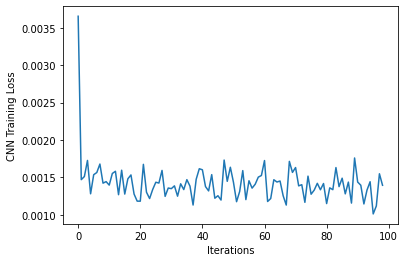

In [15]:
model1=Model()
model1,losses=train_minibatch(model1,train_eq_images,train_eqs,train_labels,16,100,10,budget=1000,constr=1,text="ABL without constraints")
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("CNN Training Loss")

In [16]:
result=eval(test_eq_images,test_labels,model1)
row = ["ABL without constraints","Handwritten Equations"]
row= row+result
print(row)
df.loc[len(df.index)] = row

(726, 15, [0, 1, 6, 8, 10, 11, 13, 14, 18, 20, 22, 23, 25, 26, 29, 30, 31, 32, 35, 36, 37, 38, 43, 44, 45, 48, 50, 51, 54, 55, 58, 59, 60, 61, 62, 63, 65, 67, 69, 70, 71, 74, 77, 78, 80, 84, 85, 86, 90, 91, 94, 95, 97, 99, 101, 103, 104, 107, 110, 112, 114, 115, 119, 120, 122, 123, 129, 130, 134, 135, 136, 139, 140, 141, 145, 148, 149, 152, 153, 155, 156, 157, 158, 159, 161, 163, 164, 167, 174, 178, 180, 183, 186, 187, 188, 190, 193, 194, 195, 196, 197, 198, 200, 201, 202, 205, 209, 211, 213, 215, 218, 219, 220, 221, 222, 223, 224, 227, 228, 229, 230, 233, 235, 236, 238, 239, 241, 242, 243, 244, 245, 246, 248, 249, 251, 252, 253, 254, 257, 258, 259, 260, 261, 263, 264, 266, 267, 268, 270, 272, 273, 275, 276, 280, 283, 284, 287, 289, 290, 294, 295, 296, 297, 301, 302, 304, 306, 307, 309, 313, 315, 318, 323, 324, 326, 327, 328, 330, 332, 334, 335, 336, 337, 338, 339, 345, 347, 350, 352, 354, 355, 356, 358, 361, 365, 366, 367, 369, 370, 371, 372, 374, 378, 379, 380, 382, 383, 384, 385, 38

We observe that without constraints, the model is unable to perform well. The explanation for this is given in the optimization section.

## Ablation 2: Reduce the background knowledge available

We remove point 3 from the available background knowledge, that X,Y and Z have constant length. Earlier, due to the fact that all the digits in the equation had constant length, we knew exactly where in the equation the '+' and '=' operators were, and the algorithm only had to find the correct assignment of 1s and 0s. After removing this from the knowledge, we have to also find the correct location of the '+' and '=' operators. So, each digit could have a  label of either '1', '0', '+' or '='.

So, this means that the search space has increased to O(4^n) from O(2^n)

iteration # 0
the equations in this batch are ['111+010=111', '0111011+0000010=0110101', '0101101+0000100=0101001', '000111+000001=100100', '00001+10111=01100', '11001001+10101000=10010000', '100+101=011', '10110+01100=00101', '01111010+00000101=01111111', '1011101+0001100=1000101', '0001111+0110001=0111110', '01+11=01', '1011+0010=1101', '0110+1001=1111', '0100000+1011000=1111000', '01+11=10']
equations before opti ['++++++++0++', '+++++++++++++++0+++++++', '+0+++++++++++++++1++1++', '+++++++++++++++++++1', '++++++0++++++++++', '++++0+++++++++++10++++++++', '++1+++++++0', '++++++++++1++++++', '++++++++0++0+++++1++++++++', '+++++++0++++++0+1++++++', '+++++++++++++++++++101+', '+++++0++', '+++++0++++1+++', '+0++0+++++++++', '+++++++0++++++00+++++++', '0001++++']
labels= [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]
c-score before opti 0
[zoopt] x: [0, 0, 0, 1, 3, 0, 1, 3, 2, 2, 2, 1, 3, 2, 0, 3, 3, 3, 0, 1, 2, 2, 1, 0, 1, 3, 3, 0, 3, 0, 1, 2, 2, 3, 3, 0, 0, 2, 2, 3, 2, 1, 2, 1, 0, 1,

Text(0, 0.5, 'CNN Training Loss')

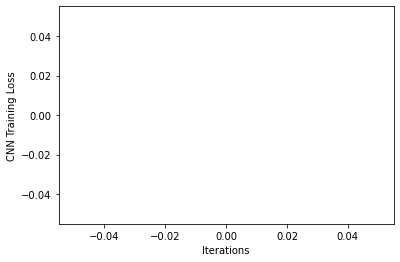

In [17]:
model2=Model()
model2,losses=train_minibatch(model2,train_eq_images,train_eqs,train_labels,16,100,10,budget=1000,constr=0.1,background_knowledge=False,text="ABL with less background knowledge")
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("CNN Training Loss")

In [18]:
result=eval(test_eq_images,test_labels,model2)
row = ["ABL with less background knowledge","Handwritten Equations"]
row= row+result
print(row)
df.loc[len(df.index)] = row
df

(0, -1, [])
0.000000 0.000000 0 0
No of zeros correctly classified: 0/663, No of ones correctly classified = 0/657 Accuracy=0.000000
['ABL with less background knowledge', 'Handwritten Equations', -1, 0.0, 0]


,Method,Task,Abduced Operator,Accuracy,F1-Score
0,ABL,Handwritten Equations,6,0.890909,0.899148
1,ABL without constraints,Handwritten Equations,15,0.550000,0.650301
2,ABL with less background knowledge,Handwritten Equations,-1,0.000000,0.000000



Out of the O(4^n) possible assignments, only O(2^n) assignments lead to valid equations. We observe that the optimization module is unable to find solutions in such a large search space.


### Ablation 3: Using greedy search instead of POSS

We try using a simple greedy search instead of POSS. The greedy search works as follows:

For M iterations, do

  For each digit in the equation, Change its value to 0 if it is a 1, and change the value to 1 if it is a 0. Record the change in consistency score due to this change. Then change the value of the digit back to the original.

  Change the value of the digit which led to maximum increase in consistency score.

end


iteration # 0
the equations in this batch are ['01110110+01100100=01110000', '100+110=010', '1011+1101=0110', '10110001+11000010=01110011', '001011+100101=000110', '1+1=1', '110011+001111=111100', '11+11=11']
equations before opti ['1111+1111++1+1+1++=1+11+1+', '+++1+++1111', '++1++111111+++', '11+++1+1+11111+1+1111+1111', '111111++1+++111111+1', '1++11', '1111+1111+111++11+11', '=+=++111']
labels= [0, 1, 1, 1, 0, 0, 1, 0]
c-score before opti 0
[zoopt] x: [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
[zoopt] value: -8.0
equation after opti ['10000001+10011010=11011000', '011+011=011', '1111+1011=1111', '01000111+01000111=01000111', '100110+111000=

Text(0, 0.5, 'CNN Training Loss')

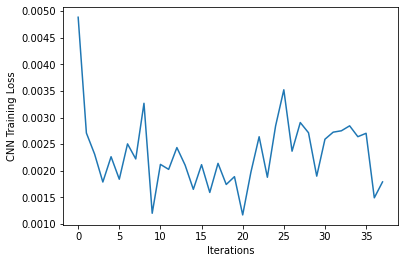

In [19]:
model3=Model()
model3,losses=train_minibatch(model3,train_eq_images,train_eqs,train_labels,8,50,10,budget=1000,constr=1,greedy=True,best_model=True,text="ABL with Greedy Search")
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("CNN Training Loss")

In [20]:
result=eval(test_eq_images,test_labels,model3)
row = ["ABL with Greedy Search","Handwritten Equations"]
row= row+result
df.loc[len(df.index)] = row

(794, 9, [0, 1, 3, 6, 8, 10, 11, 12, 13, 14, 18, 20, 22, 23, 25, 26, 30, 31, 32, 33, 35, 36, 37, 38, 43, 45, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 67, 71, 73, 74, 77, 78, 80, 84, 85, 86, 87, 90, 91, 94, 95, 97, 98, 99, 101, 104, 105, 107, 110, 112, 114, 115, 119, 120, 122, 123, 125, 126, 129, 134, 135, 136, 137, 139, 140, 141, 143, 144, 148, 149, 152, 153, 155, 157, 158, 159, 160, 161, 163, 164, 167, 169, 170, 174, 175, 176, 178, 179, 180, 183, 188, 189, 190, 193, 194, 195, 196, 198, 200, 201, 202, 205, 208, 209, 212, 213, 215, 218, 219, 220, 221, 222, 223, 224, 227, 228, 229, 232, 233, 235, 236, 238, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 257, 258, 259, 260, 261, 263, 264, 265, 266, 270, 272, 273, 275, 276, 280, 281, 282, 283, 284, 285, 286, 287, 289, 290, 293, 295, 296, 297, 301, 302, 304, 305, 306, 307, 309, 310, 313, 314, 318, 319, 324, 326, 327, 328, 330, 332, 335, 336, 337, 339, 340, 345, 347, 348, 349, 350, 351, 352, 354, 355, 356,

We observe the following:
1. The greedy strategy takes a lot more time for optimization compared to POSS
2. The loss fluctuates, compared to POSS, in which the loss was almost monotonically decreasing
3. The results achieved on the test set are not as good as the original approach, but better than the other ablations. When run for 100 iterations, the result is close to the original approach. Above I have run it for 50 iterations as it takes a long time to run.



# Comparision with BiLSTM

We compare the results of ABL with BiLSTM. BiLSTM is not expected to perform well, as Neural Networks usually perform poorly on reasoning tasks (especially with less data). Also, the BiLSTM is at a disadvantage, as it does not make use of the background knowledge available



### Defining the BiLSTM model

In [21]:
class BiLSTM(torch.nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.lstm_1 = torch.nn.LSTM(7 * 7 * 64, 128,bidirectional=True)
        self.linear_2 = torch.nn.Linear(128*2, 2)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()
        # self.criterion = torch.nn.CrossEntropyLoss()
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = x.reshape(x.size(0),1,x.size(1),x.size(2))
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0),1,-1)
        # print(x.shape)
        x = self.lstm_1(x)[0]
        # print(x.shape)
        x = torch.mean(x, 0)
        # print(x.shape)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

    def train(self,X,y,optimizer,criterion):
      X,y=X.to(device),y.to(device)
      optimizer.zero_grad()
      pred = self(X)
      # print(y)
      loss = criterion(pred, y.long())
      loss.backward()
      optimizer.step()
      return loss
    

### Define the train and test functions for the BiLSTM

If running on Colab, it is recommended to shift to GPU runtime for this part

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_lstm(lstm,train_eq_images,train_labels,no_of_epochs=800):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.RMSprop(lstm.parameters(), lr=0.001)
  losses=[]
  for i in range(no_of_epochs):
    # print(i)
    index=random.choice(range(len(train_eq_images)))
    x=train_eq_images[index]
    y=train_labels[index]
    loss=lstm.train(torch.Tensor(x),torch.Tensor([y]),optimizer,criterion)
    losses.append(loss)
    writer.add_scalar("BiLSTM/train", loss, i)
  return losses

def test_lstm(lstm,test_eq_images,test_labels):
  preds=[]
  i=0
  for x in test_eq_images:
    # print(x)
    x=torch.Tensor(x)
    x=x.to(device)
    i+=1
    pred=lstm(x)
    pred=np.argmax(pred.cpu().detach(),axis=1)
    preds.append(pred)
  accuracy=accuracy_score(preds,test_labels)
  f1=f1_score(preds,test_labels)
  return [accuracy,f1]
  


Text(0, 0.5, 'training loss')

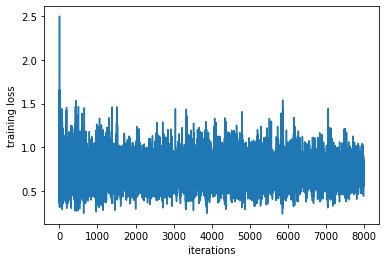

In [23]:
lstm=BiLSTM()
lstm.to(device)
losses=train_lstm(lstm,train_eq_images,train_labels,8000)
plt.plot(losses)
plt.xlabel("iterations")
plt.ylabel("training loss")

In [24]:
result=test_lstm(lstm,test_eq_images,test_labels)
row=["BiLSTM","Handwritten Equations","NA"]
row= row+result
df.loc[len(df.index)] = row

['BiLSTM', 'Handwritten Equations', 'NA', 0.49772727272727274, 0.5623762376237623]


As we can observe, the BiLSTM is not really able to learn anything, and achieves an accuracy of around 50%, which is equivalent to random guessing.

It will probably require a lot more data and/or computational power to be able to perform well

# Task 2: Equations with Random Symbols

In the earlier task, equations were created with images from the MNIST Images. While in this task, equations were constructed from randomly selected characters sets of the Omniglot dataset, i.e, random symbols are used to represent '1', '0', '+', '='.

### Generate and the dataset and view examples of the dataset.



['110+111=001', '1000+0101=1110', '011+010=001', '010+001=101', '101+001=100', '1+1=1', '110+010=100', '1+1=1', '10011100+10110100=00101000', '1+1=1', '010+010=000', '110+001=100', '1110110+1010011=0100101', '1111+1000=0011', '01010011+10111010=11101001', '10+01=10', '1+1=0', '1+1=1', '110000+110101=000101', '1+1=1', '11000+00010=11010', '10000110+01111101=10011000', '00100+11100=11000', '1101100+0001111=1110100', '10011000+11101001=01110001', '00011+01101=10111', '101110+001010=100100', '11011000+10101001=11101101', '1+1=0', '1+1=1', '1+1=0', '0111+0100=1011', '1+1=0', '011+111=010', '01+10=11', '0010111+1000101=0111011', '10+10=00', '11+11=11', '10+11=01', '1111+1010=1000', '111000+100111=011111', '1010+0001=1111', '110+111=001', '110110+011101=000111', '10+01=11', '0011000+1011011=0010100', '0001+1101=1100', '01000010+01101010=01001010', '011+011=000', '1000101+1010000=1001010', '0101111+0111001=0010110', '00001011+01100101=00011010', '10+11=01', '0100+1111=1010', '1+1=0', '010+101=

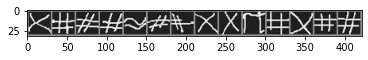

Negative Sample


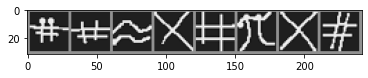

In [25]:
eqs1,labels1=generate_equations()
print(eqs1)
print(labels1)
train_eqs1,test_eqs1,train_labels1,test_labels1=train_test_split(eqs1,labels1,train_size=0.8)
image_pools1 = get_image_pools("/content/dataset/random_images", ['0', '1', '10', '11'])
train_pool1, test_pool1 = split_pool(image_pools1, 0.8)
train_eq_images1=generate_equation_images(train_eqs1,['0', '1', '+', '='],(28,28),train_pool1)
test_eq_images1=generate_equation_images(test_eqs1,['0', '1', '+', '='],(28,28),test_pool1)
display_equations(train_eq_images1,train_labels1)

Train and Test the ABL model on this task

iteration # 0
the equations in this batch are ['1+1=1', '10001110+11010110=01011000', '0001+0101=1000', '11100011+11010111=11011001', '1+1=0', '10000010+10111000=00111010', '101+001=100', '00110+01111=01010', '1+1=0', '00100111+01110000=11100000', '1+1=0', '00010+10011=10001', '00110+00011=01101', '1+1=0', '1+1=1', '011+111=101']
equations before opti ['111==', '0111====01+1===+011====1==', '=111==1=1=====', '===1=0==1=====1==1111=====', '1=1=1', '1==11==101==1====1=11=11==', '0=0=010=1=+', '1+00=0=11==1===+=', '10==1', '1+11===+===0=11=0=11001+11', '==10=', '=111====+=1+1=1+1', '1==11==0=0=11=0==', '1==1=', '===+1', '+1+=111=1==']
labels= [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0]
c-score before opti -1
[zoopt] x: [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0

Text(0, 0.5, 'CNN Training Loss')

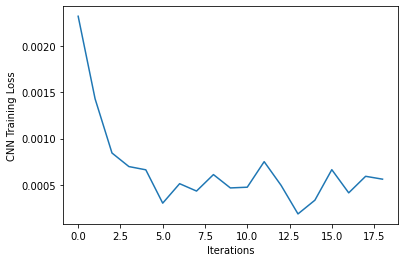

In [32]:
model4=Model()
model4,losses=train_minibatch(model4,train_eq_images1,train_eqs1,train_labels1,16,100,10,budget=1000,constr=0.1,text="ABL - Random Symbol Equations")
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("CNN Training Loss")

ABL is able to do well on this task as well

In [33]:
result=eval(test_eq_images1,test_labels1,model4)
row = ["ABL","Random Symbol Equations"]
row= row+result
df.loc[len(df.index)] = row

(1227, 6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 236, 237, 2

# Summarize Results

Lets view the results of all experiments. I ran the model for the Random Symbol classification task twice. I hypothesize that the poor performance on the first attempt was due to the algorithm getting stuck in a bad local minima

In [34]:
df

,Method,Task,Abduced Operator,Accuracy,F1-Score
0,ABL,Handwritten Equations,6,0.890909,0.899148
1,ABL without constraints,Handwritten Equations,15,0.550000,0.650301
2,ABL with less background knowledge,Handwritten Equations,-1,0.000000,0.000000
3,ABL with Greedy Search,Handwritten Equations,9,0.601515,0.645910
4,BiLSTM,Handwritten Equations,NA,0.497727,0.562376
5,ABL,Random Symbol Equations,0,0.518939,0.515170
6,ABL,Random Symbol Equations,6,0.929545,0.929755


And lets view the loss curves for all experiments

In [31]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 466), started 2:02:29 ago. (Use '!kill 466' to kill it.)

<IPython.core.display.Javascript object>

The main observations from the notebook are as follows:

1. ABL is able to learn the correct operator, and achieve good predictive accuracy, for both the handwritten equation and random symbol equation tasks. It is able to achieve this despite having seen very little data, and without consuming too much computational power. It performs better for the handwritten operation task, as the images there are more easily distinguished.
2. ABL performs poorly when constraints are removed from the optimization module. As when constraints are removed, δ can simply mark all pseudo-labels as “wrong”, i.e., letting δ[p(X)] = p(X) and ask logical abduction to do all the learning jobs. In this case, ABL can always abduce a consistent ∆p ∪ ∆. However, this means that the logical abduction have to learn the knowledge model ∆ without any influence from the perception model p and the raw data X.
3. ABL performs poorly when background knowledge is reduced. This is because, in this case, the size of the search space increases from O(2^n) to O(4^n). It gets a 0% accuracy as it is unable to even learn the structure of the equation, and classifies each instance as invalid
4. ABL achieves good performance even when greedy search is used instead of POSS. However in this case, the optimization takes much longer time, and the loss fluctuates instead of monotonically decreasing.
5. BiLSTM performs poorly on these tasks. It cannot do much better than random classification.
